# Landmark Augmentation

Increase landmark data by simulating variations found in real videos we don't have.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Augmentation Variation

## Mirroring (Horizontal Flip)
**Imitation**: This simulates scenarios involving left-handed and right-handed individuals.<br>
**How It Helps**:
*   Balances the dataset by effectively doubling the diversity of signs.
*   Helps the model learn symmetry in gestures, reducing bias towards one-handedness.

**Implementation:** Negate the x coordinates.

In [2]:
def mirror_landmarks(landmarks):
    mirrored = landmarks.copy()
    mirrored[:, 0] = -mirrored[:, 0]  # Flip X-axis
    return mirrored

## Rotation
**Imitation:** Models slight changes in camera angle or body posture.

**How It Helps:**
* Makes the model robust to minor misalignments during video capture.
* Prepares the model for non-perfect frontal views of gestures.

**Implementation:** Apply a 2D rotation transformation to landmarks.

In [3]:
def rotate_landmarks(landmarks, angle_deg=10):
    angle_rad = np.radians(angle_deg)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    return landmarks[:, :2] @ rotation_matrix.T  # Apply rotation on X-Y plane only

## Scaling
**Imitation:** Accounts for variations in subject distance from the camera.

**How It Helps:**
* Allows the model to generalize to different scales of gestures.
* Reduces sensitivity to variations in distance from the camera.

**Implementation:** Multiply all coordinates by a scaling factor.

In [4]:
def scale_landmarks(landmarks, scale_factor=1.1):
    scaled = landmarks.copy()
    scaled[:, :2] *= scale_factor  # Scale X-Y
    return scaled

## Translation
**Imitation:** Simulates shifts in the camera's viewpoint.

**How It Helps:**
* Reduces overfitting to specific camera positioning.
* Prepares the model for scenarios where the subject moves within the frame.

**Implementation:** Add a constant value to all x, y, and z coordinates.

In [5]:
def translate_landmarks(landmarks, shift=(0.05, -0.05)):
    translated = landmarks.copy()
    translated[:, :2] += np.array(shift)  # Shift X-Y
    return translated

## Adding Noise (Jitter)
**Imitation:** Models real-world variations or inaccuracies in landmark detection.

**How It Helps:**
* Improves robustness to noisy data or detection errors during preprocessing.
* Encourages the model to learn key patterns, not rely on overly precise coordinates.

**Implementation:** Add random small values to the coordinates.

In [6]:
def add_noise(landmarks, noise_std=0.01):
    noisy = landmarks.copy()
    noise = np.random.normal(0, noise_std, landmarks[:, :2].shape)  # Add noise to X-Y
    noisy[:, :2] += noise
    return noisy

# Augmentation

Instead of implementing the same augmentation for each video, randomness is used for every type of augmentation. This imitates the random quality of videos in real situations.

In [7]:
def augment_landmarks(landmarks):
    # Determine augmentations ONCE per video
    mirror = random.random() < 0.5
    angle = random.uniform(-5, 5) if random.random() < 0.5 else 0
    scale = random.uniform(0.8, 1.2) if random.random() < 0.5 else 1
    shift = np.random.uniform(-0.1, 0.1, size=(2,)) if random.random() < 0.5 else (0, 0)
    noise_std = 0.02 if random.random() < 0.5 else 0

    augmented_frames = []
    for frame in landmarks:
        augmented = frame.copy()

        if mirror:
            augmented = mirror_landmarks(augmented)

        if angle != 0:
          augmented[:, :2] = rotate_landmarks(augmented, angle_deg=angle)

        if scale != 1:
            augmented = scale_landmarks(augmented, scale_factor=scale)

        if np.any(shift != 0):
            augmented = translate_landmarks(augmented, shift=shift)

        if noise_std != 0:
            augmented = add_noise(augmented, noise_std=noise_std)

        augmented_frames.append(augmented)

    return np.array(augmented_frames)

In [8]:
# Set seed for consistency
# random.seed(66)
# np.random.seed(66)

# Load landmarks
landmarks = np.load("/content/drive/MyDrive/Omdena/sign_language_recognition/landmark_non_zero/adik/kenji.npy")

# Apply augmentation consistently across all frames of the video
augmented_landmarks_all = augment_landmarks(landmarks)

# Visualization

In [9]:
# Function to plot 2D landmarks for a single frame
def plot_landmarks_2d(landmarks, title="Landmarks"):
    plt.scatter(landmarks[:, 0], landmarks[:, 1], label="Landmarks")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)

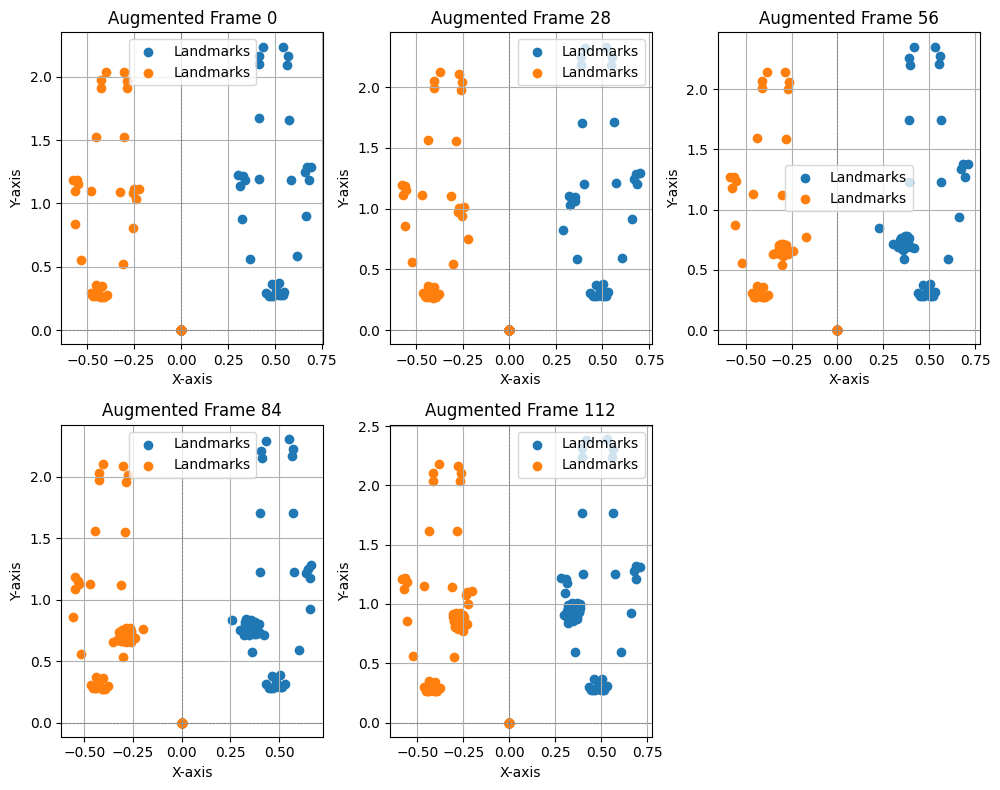

In [11]:
# Visualize a subset of frames
subset_indices = np.linspace(0, len(landmarks) - 1, 5, dtype=int)  # Choose 5 evenly spaced frames
plt.figure(figsize=(10, 8))
for i, idx in enumerate(subset_indices, start=1):
    plt.subplot(2, 3, i)
    plot_landmarks_2d(landmarks[idx], title=f"Original Frame {idx}")
    plot_landmarks_2d(augmented_landmarks_all[idx], title=f"Augmented Frame {idx}")

plt.tight_layout()
plt.show()

#Augment non-zero landmark 3 times and save

In [10]:
DATA_DIR = '/content/drive/MyDrive/Omdena/sign_language_recognition/landmark_non_zero'
SAVE_DIR = '/content/drive/MyDrive/Omdena/sign_language_recognition/augmented_landmark_non_zero'

os.makedirs(SAVE_DIR, exist_ok=True)

for word in os.listdir(DATA_DIR):
    word_dir = os.path.join(DATA_DIR, word)
    save_word_dir = os.path.join(SAVE_DIR, word)
    os.makedirs(save_word_dir, exist_ok=True)

    for landmark_file in os.listdir(word_dir):
        base_name, ext = os.path.splitext(landmark_file)

        for i in range(3): # Loop 3 times for each video
            save_path = os.path.join(save_word_dir, f"{base_name}_aug_{i}{ext}")

            # Skip if the keypoints file already exists
            if os.path.exists(save_path):
                continue

            print(f"Processing {word}/{landmark_file}, augmentation {i+1}/3")
            landmarks = np.load(os.path.join(word_dir, landmark_file))
            augmented_landmarks_all = augment_landmarks(landmarks)
            np.save(save_path, augmented_landmarks_all)  # Save as .npy

Processing maaf/1.npy, augmentation 1/3
Processing maaf/1.npy, augmentation 2/3
Processing maaf/1.npy, augmentation 3/3
Processing maaf/dina_maaf.npy, augmentation 1/3
Processing maaf/dina_maaf.npy, augmentation 2/3
Processing maaf/dina_maaf.npy, augmentation 3/3
Processing maaf/kenji.npy, augmentation 1/3
Processing maaf/kenji.npy, augmentation 2/3
Processing maaf/kenji.npy, augmentation 3/3
Processing maaf/nadya.npy, augmentation 1/3
Processing maaf/nadya.npy, augmentation 2/3
Processing maaf/nadya.npy, augmentation 3/3
Processing maaf/Arun.npy, augmentation 1/3
Processing maaf/Arun.npy, augmentation 2/3
Processing maaf/Arun.npy, augmentation 3/3
Processing maaf/Anastasiia.npy, augmentation 1/3
Processing maaf/Anastasiia.npy, augmentation 2/3
Processing maaf/Anastasiia.npy, augmentation 3/3
Processing maaf/Deepa.npy, augmentation 1/3
Processing maaf/Deepa.npy, augmentation 2/3
Processing maaf/Deepa.npy, augmentation 3/3
Processing maaf/shikha.npy, augmentation 1/3
Processing maaf/shi

In [11]:
DATA_DIR = '/content/drive/MyDrive/Omdena/sign_language_recognition/landmark_with_zero'
SAVE_DIR = '/content/drive/MyDrive/Omdena/sign_language_recognition/augmented_landmark_with_zero'

os.makedirs(SAVE_DIR, exist_ok=True)

for word in os.listdir(DATA_DIR):
    word_dir = os.path.join(DATA_DIR, word)
    save_word_dir = os.path.join(SAVE_DIR, word)
    os.makedirs(save_word_dir, exist_ok=True)

    for landmark_file in os.listdir(word_dir):
        base_name, ext = os.path.splitext(landmark_file)

        for i in range(3): # Loop 3 times for each video
            save_path = os.path.join(save_word_dir, f"{base_name}_aug_{i}{ext}")

            # Skip if the keypoints file already exists
            if os.path.exists(save_path):
                continue

            #print(f"Processing {word}/{landmark_file}, augmentation {i+1}/3")
            landmarks = np.load(os.path.join(word_dir, landmark_file))
            augmented_landmarks_all = augment_landmarks(landmarks)
            np.save(save_path, augmented_landmarks_all)  # Save as .npy

# Push to Dags

In [ ]:
!pip install -q dagshub

from dagshub.notebook import save_notebook

save_notebook(repo="Omdena/JakartaIndonesia_SignLanguageTranslation", path="preprocessing", branch="kenji")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.2/252.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.7 MB/s eta 0:00:00
